# 加载必要的库

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba # 结巴分词
# gensim用来加载预训练word vector
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings("ignore")
# 用来解压
import bz2

In [2]:
# 解压词向量, 有可能需要等待1-2分钟
# with open("../models/embeddings/sgns.zhihu.bigram", 'wb') as new_file, open("../models/embeddings/sgns.zhihu.bigram.bz2", 'rb') as file:
#     decompressor = bz2.BZ2Decompressor()
#     for data in iter(lambda : file.read(100 * 1024), b''):
#         new_file.write(decompressor.decompress(data))

# 装载模型 & 简单测试

In [2]:
# 使用gensim加载预训练中文分词embedding, 有可能需要等待1-2分钟
cn_model = KeyedVectors.load_word2vec_format('../models/embeddings/sgns.zhihu.bigram', 
                                             binary=False, unicode_errors="ignore")

In [4]:
# 由此可见每一个词都对应一个长度为300的向量
embedding_dim = cn_model['山东大学'].shape[0]
print('词向量的长度为{}'.format(embedding_dim))


词向量的长度为300


In [5]:
# 计算相似度
cn_model.similarity('橘子', '橙子')

0.66128117

In [6]:
# 计算相似度
cn_model.similarity('好', '不好')

0.46855795

In [7]:
# 找出不同的词
test_words = '老师 会计师 程序员 律师 医生 坏人'
test_words_result = cn_model.doesnt_match(test_words.split())
print('在 '+test_words+' 中:\n不是同一类别的词为: %s' %test_words_result)

在 老师 会计师 程序员 律师 医生 坏人 中:
不是同一类别的词为: 坏人


# 处理数据

In [8]:
import pandas as pd
path = '../data/'

In [9]:
ratings = pd.read_csv(path + 'ratings.csv')

print('用户数据：%d' % ratings.userId.unique().shape[0])
print('评分数目：%d' % ratings.shape[0])

用户数据：738701
评分数目：2125056


In [10]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'comment', 'like'], dtype='object')

In [11]:
ratings[(ratings.rating==5)].\
    sample(10000)[['comment','rating']].to_csv('../data/posPrefect.csv',encoding='utf_8_sig')
print('积极数据保存成功')

积极数据保存成功


In [12]:
ratings[(ratings.rating==1)].\
    sample(10000)[['comment','rating']].to_csv('../data/negPrefect.csv',encoding='utf_8_sig')
print('消极数据保存成功')

消极数据保存成功


In [13]:
import pandas as pd
path = '../data/'
pos = pd.read_csv(path + 'posPrefect.csv')
neg = pd.read_csv(path + 'negPrefect.csv')
pos = pos['comment'].tolist()
neg = neg['comment'].tolist()

In [14]:
# 处理合并数据
train_tokens = []
train_target = []

for text in pos:
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    cut = jieba.cut(text)
    
    cut_list = [i for i in cut]
    for i,word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
        except:
            cut_list[i] = 0
    train_tokens.append(cut_list)
    train_target.append(1)
for text in neg:
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    cut = jieba.cut(text)
    
    cut_list = [i for i in cut]
    for i,word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
        except:
            cut_list[i] = 0
    train_tokens.append(cut_list)
    train_target.append(0)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.814 seconds.
Prefix dict has been built successfully.


In [15]:
len(train_tokens)

20000

In [16]:
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)
np.mean(num_tokens)

18.1142

In [17]:
np.max(num_tokens)

92

In [18]:
len(num_tokens)

20000

In [19]:
np.sum(num_tokens < 100)/20000

1.0

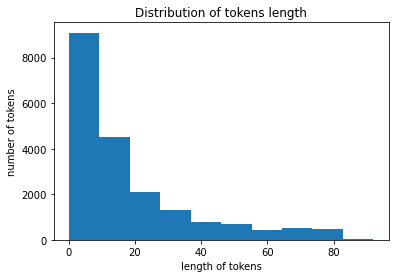

In [20]:
# 绘制tokens长度图
plt.hist(num_tokens)
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [21]:
# 用来将tokens转换为文本
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text

reverse_tokens(train_tokens[1])

'班恩：我骑着我的摩托车啦啦啦'

In [22]:
# 只使用前50000个词
num_words = 50000
embedding_dim = 300
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[ cn_model.index2word[i] ]
embedding_matrix = embedding_matrix.astype('float32')

In [23]:
embedding_matrix.shape

(50000, 300)

# 进行padding和truncating

In [24]:
# 进行padding和truncating， 输入的train_tokens是一个list
# 返回的train_pad是一个numpy array
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
max_tokens = 90
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,padding='pre', truncating='pre')
train_pad[ train_pad>=num_words ] = 0

In [25]:
import numpy as np
train_target = np.array(train_target)

In [26]:
data_set = [(train_pad[i],train_target[i]) for i in range(len(train_target))]

In [27]:
from torch.utils.data import random_split,Subset,DataLoader

dataSet_length = len(data_set)
train_size = int(0.8*dataSet_length)
train_db,val_db = random_split(data_set,[train_size,dataSet_length-train_size])

train_loader = DataLoader(train_db, batch_size=9,shuffle=True)
test_loader = DataLoader(val_db, batch_size=9,shuffle=True)


# 构建RNN网络

In [28]:
import torch
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,batch_size,num_layers=1):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        
        self.embedding = nn.Embedding.from_pretrained(torch.Tensor(embedding_matrix))
        self.embedding.requires_grad = False
        
        self.rnn = nn.RNN(input_size,hidden_size,num_layers)
        self.linear = nn.Linear(hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim = -1)
        
        
    def forward(self,x,hidden):
        x = self.embedding(x)
        x = x.transpose(0,1)
        output,hn = self.rnn(x,hidden)
        output = self.linear(output[-1])
        output = self.softmax(output)
        return output
    
    def initHidden(self):
        return torch.zeros(self.num_layers,self.batch_size,self.hidden_size)

In [29]:

# net = RNN(input_size = 300,hidden_size = 128,output_size = 2,batch_size = 9)
# print(net)
# hidden = net.initHidden()
# output = net(d.long(),hidden)
# print(output.shape)

# 训练

# 

In [33]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Batch_size = 32
N_EPOCHS = 50

net = RNN(input_size = 300,hidden_size = 128,output_size = 2,batch_size = Batch_size)
net = net.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
print(device)
print(net)

cuda
RNN(
  (embedding): Embedding(50000, 300)
  (rnn): RNN(300, 128)
  (linear): Linear(in_features=128, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=-1)
)


In [36]:
def train(train_data,net,batch_size=20):
    train_loss = 0
    train_acc = 0
    
    data = DataLoader(train_data, batch_size=batch_size,shuffle=True)
    
    for i,(text,label) in enumerate(data):
        optimizer.zero_grad()
        
        text = text.long().to(device)
        label = label.long().to(device)
        
        hidden = net.initHidden().to(device)
        output = net(text,hidden)
        loss = criterion(output,label)
        
        train_acc += (label.view(-1,1)==output.topk(1)[1]).sum().item()
        train_loss +=loss.item() 
        
        loss.backward()
        optimizer.step()
    
    return train_loss/len(train_data),train_acc / len(train_data)


def valid(val_db,net,batch_size=20):
    val_loss = 0
    val_acc = 0
    
    data = DataLoader(val_db, batch_size=batch_size,shuffle=True)
    
    for text,label in data:
        with torch.no_grad():
            text = text.long().to(device)
            label = label.long().to(device)

            hidden = net.initHidden().to(device)
            output = net(text,hidden)
            loss = criterion(output,label)
            
            val_acc += (label.view(-1,1)==output.topk(1)[1]).sum().item()
            val_loss +=loss.item()
            
    return val_loss/len(val_db),val_acc / len(val_db)

# print(train(train_db,net,Batch_size))
# print(valid(val_db,net,Batch_size))

In [37]:
import time 

start_time = time.time()
for epoch in range(N_EPOCHS):
    
    train_loss,train_acc = train(train_db,net,Batch_size)
    valid_loss,valid_acc = valid(val_db,net,Batch_size)
    
    secs = int(time.time()-start_time)
    
    mins = secs/60
    secs = secs%60
    
    if ((epoch+1)%10==0):
        print('Epoch: %d' % (epoch + 1), " | time in %d minites, %d seconds" % (mins, secs))
        print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
        print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')


BrokenPipeError: [Errno 32] Broken pipe